Machine Learning

Random Forest Classifier

Adaboost Model Classifier

In [1]:
!python --version

Python 3.6.1


In [2]:
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import csv
import statistics as stats
import scipy.stats as st
# import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.dates
import numpy as np
import seaborn as sns; sns.set()
import mplfinance
get_ipython().run_line_magic('matplotlib', 'inline')

from matplotlib import style
from matplotlib.dates import num2date, date2num


from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score,f1_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc, accuracy_score

#### Load Dataset & set Date as index

In [3]:
# Yields
df = pd.read_csv("ARG_USD.csv",sep=',')

# Reverse order in time
df = df.iloc[::-1]
df['Date'] = df['Date'].apply(lambda x: pd.Timestamp(x))
df.set_index(df['Date'],inplace=True)
df.rename(columns={' Y5CDS ': 'Y5CDS'}, inplace = True)
df = df.drop('Date',1)

In [4]:
df_CDS = df[['Y5CDS']]

In [5]:
# We only keep these tickers
bonds = ['AA19', 'AA21', 'AY24', 'AA22', 'A2E3', 'AA26', 'AA27', 'AA28','DICY', 'AA36',
         'AA46', 'PARY', 'AA48', 'CY17','Y5CDS']
df_bonds = df[bonds]
df_bonds.tail()

,AA19,AA21,AY24,AA22,A2E3,AA26,AA27,AA28,DICY,AA36,AA46,PARY,AA48,CY17,Y5CDS
Date,,,,,,,,,,,,,,,
2018-12-09,3.667,9.553,11.152,10.317,9.909,10.528,10.554,10.202,10.893,10.217,10.214,9.626,9.770,9.802,674.236
2018-12-10,3.715,9.926,11.759,10.757,10.211,10.816,10.786,10.485,11.107,10.410,10.393,9.747,9.946,9.953,694.942
2018-12-11,3.759,10.026,11.687,10.818,10.326,10.889,10.892,10.532,11.089,10.460,10.436,9.822,10.006,9.955,699.213
2018-12-12,3.647,9.962,11.907,10.711,10.202,10.756,10.787,10.379,11.147,10.342,10.293,9.697,9.880,9.815,689.901
2018-12-13,3.624,10.035,11.884,10.698,10.175,10.771,10.782,10.386,11.208,10.317,10.274,9.712,9.873,9.837,706.007


#### Feature engineering

In [6]:
# Sub-sample data

def webdata(bond):
        df = df_bonds[[bond]]
        data = []
        for i in df[bond].keys():
             data.append((i.toordinal(),df[bond][i]))
        return data , df

In [7]:
# Build RSI

def rsiFunc2(df,stock, n=14):
    prices = df[stock].to_list()

    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed>=0].sum()/n
    down = -seed[seed<0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1.+rs)

    for i in range(n, len(prices)):
        delta = deltas[i-1] # cause the diff is 1 shorter

        if delta>0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(n-1) + upval)/n
        down = (down*(n-1) + downval)/n

        rs = up/down
        rsi[i] = 100. - 100./(1.+rs)
        
    
    dates = list(df.index.map(lambda t: t.strftime('%Y-%m-%d')))
    rsi_values = list(map(lambda x, y: [x,y], dates, list(rsi)))
    
    return rsi_values

In [8]:
# RSI trade signal 
# Notice that since we are working with bonds the buy/sell criteria is counterchanged. 
def trade_eval_RSI_bis(rsi,rsi_1):
    # RSI >= 70: Overbought signal (equity)
    if rsi >= 70:
        return  1#'buy' for bonds # Sell for equity
    # RSI <= 30: Oversold signal (equity) - Overbought for bonds
    if rsi <= 30:
        return 0#'sell' for bonds # Buy for equity    
    else:
        if  rsi >= rsi_1:
            return 0 #'Sell' for bonds # Buy for equity --> The RSI continues to grow ...the bond price continues to fall
        if rsi < rsi_1:
            return 1 #'Buy' for bonds # Sell for equity --> The RSI continues to grow ...the bond price continues to grow 

In [9]:
# Moving average - choose window
def movingaverage2(stock,df,window):
    cumsum, smas = [0], []
    values1 = df[stock].to_numpy()
    for i, x in enumerate(values1, 1):
        cumsum.append(cumsum[i-1] + x)
        if i<window:
            moving_ave = 0
            smas.append(moving_ave)
        if i>=window:
            moving_ave = (cumsum[i] - cumsum[i-window])/window
            smas.append(moving_ave)          
    dates = list(df.index.map(lambda t: t.strftime('%Y-%m-%d')))
    ma = list(map(lambda x, y: [x,y], dates, smas))
    return ma

In [10]:
# MACD
def macd(time_series, slow_period=26, fast_period=12):
    emaslow = time_series.ewm(span=slow_period, adjust=False).mean()
    emafast = time_series.ewm(span=fast_period, adjust=False).mean()
    return emafast, emaslow, emafast - emaslow

In [11]:
# MACD: trading signal
def trade_eval_macd(macd_line,signal_line,diff_macd):
    
# Bonds - Sell / Equity - Buy: MACD bull crosses the signal line, it is a bullish signal, 
# which indicates that it may be time to buy
    if macd_line > 0 and signal_line > 0 and macd_line > signal_line and diff_macd>0:
        return 'sell'    
# Bonds - Buy / Equity - Sell: MACD falls below the signal line, it is a bearish signal, 
# which indicates that it may be time to sell
    elif macd_line < 0 and signal_line < 0 and macd_line < signal_line and diff_macd<0:
        return 'buy'
    elif diff_macd<0:
        return 'buy' # Bonds - Buy / Equity - Sell
    else:
        return 'sell' # Bonds - Sell / Equity - Buy

In [12]:
# Moving STD - choose window
def day20_std2(stock,df,window,col):
    std = []
    diff = []
    values1 = df[stock].to_numpy()
    for i in range(len(values1)):
        if i < window:
            std.append(np.nan)
        if i >= window:
            std_value = stats.stdev(values1[i-window:i-1])
            std.append(std_value)
    return std

In [13]:
# Bollinger bands
def bollinger_bands2(stock,df, window = 50):
    middle_band = movingaverage2(stock,df,20)
    std_list = day20_std2(stock,df,20,1)
    upper_band_l = []
    lower_band_l = []
    for i in range(0,len(middle_band)):
        if i < window or i == window:
            upper_band = np.nan
            upper_band_l.append(upper_band)

            lower_band = np.nan
            lower_band_l.append(lower_band)

        if i > window:
            upper_band = middle_band[i][1] + (std_list[i] * 2)
            upper_band_l.append(upper_band)
            lower_band = middle_band[i][1] - (std_list[i] * 2)
            lower_band_l.append(lower_band)

    middle_band_df = pd.DataFrame(middle_band)
    upper_band_df = pd.DataFrame(upper_band_l)
    lower_band_df = pd.DataFrame(lower_band_l)
    
    return middle_band_df,upper_band_df,lower_band_df

In [14]:
# Trade label: Buy signal subject to threshold 
# Note: Since we are working with bond yields the buy signal will be set to one if the yield goes below thr
# Note: Change criteria and code to fit equities

def trade_eval(value,future,thr):
    if future <= (value-thr):
        return 1 #'Buy'
    else:
        return 0

In [15]:
# Buid dataset
def candle(stock,p_f):
    quotes , df = webdata(stock)
    dates = list(df.index.map(lambda t: t.strftime('%Y-%m-%d')))
    sma = list(df[stock])
    data = pd.DataFrame(sma, index=dates, columns=["sma"])

    # MOVING AVG
    ma50_data = pd.DataFrame(movingaverage2(stock,df,50), columns=['Date',"ma50"]).set_index('Date')
    ma200_data = pd.DataFrame(movingaverage2(stock,df,200), columns=['Date',"ma200"]).set_index('Date')
    
    # RSI
    quotes_rsi = rsiFunc2(df,stock, n=14)
    rsi_data = pd.DataFrame(quotes_rsi, columns=["Date","rsi"]).set_index('Date')

    # MACD
    emaslow, emafast, macd_line = macd(df)
    signal_line = macd_line.ewm(span=9, adjust=False).mean()
    diff = macd_line - signal_line
    signal = diff.iloc[:,0]
    df[stock +'macd'] = signal.values 
    
    df = df.join(ma50_data, lsuffix='Date', rsuffix='Date')
    df = df.join(ma200_data, lsuffix='Date', rsuffix='Date')
    df = df.join(rsi_data, lsuffix='Date', rsuffix='Date')

# Bollinger Bands
    middle, upper, lower = bollinger_bands2(stock,df)    
    z = middle.iloc[:,1]
    df[stock+'middle'] = z.values
    df[stock+'upper'] = upper.values
    df[stock+'lower'] = lower.values
    df[stock+'percentBB'] = (df[stock].add(-df[stock+'lower']))/(df[stock+'upper'].add(-df[stock+'lower']))
    df[stock+'Bandwidth'] = (df[stock+'upper'].add(-df[stock+'lower']))/df[stock+'middle']
    
# Compute Future Yield & Trade Evaluation

    # Define Buy labels: We plan to predict the correct label for the next five days.
    # Notice that the code works for different time frames 
    
#     p_f = 5
    df[stock+'_future_'] = df[stock].shift(periods=-p_f,freq='D',axis='index') 
    df[stock+'_trade_eval'] = df.apply(lambda row : trade_eval(row[stock],
                                                               row[stock+'_future_'],0.25),
                                                               axis=1)
    # Define RSI Buy signal
    p_p = 1 # or -1 depeding on how the data is loaded initially
    df[stock+'_rsi_past'] = df[stock].shift(periods=p_p,freq='D',axis='index') 
    df[stock+'_rsi_trade_eval'] = df.apply(lambda row : trade_eval_RSI_bis(row['rsi'],
                                                                    row[stock+'_rsi_past']),
                                                                   axis=1)
    # 50 vs. 200 dias --
    df[bond+'_ma50vs200'] = (df['ma200']/df['ma50']-1)*100
    df[bond+'_actvsma50'] = (df[bond]/df['ma50']-1)*100
    df[bond+'_actvsma200'] = (df[bond]/df['ma200']-1)*100
    
    
# Plot     
    fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(20,20))

    ax1.plot(df.index[200:],df[stock][200:])
    ax1.plot(df.index[200:],ma50_data.ma50[200:])
    ax1.plot(df.index[200:],ma200_data.ma200[200:])

    ax1.set_title(stock + " - MA50 & MA200")
    ax1.grid(True)
    ax1.format_xdata = mdates.DateFormatter('%Y-%m-%d')

    ax2.plot(rsi_data.index[200:],rsi_data.rsi[200:])
    ax2.axhline(y=30,linewidth=2, color='b')
    ax2.axhline(y=70,linewidth=2, color='b')   
    ax2.set(title = 'RSI', ylabel='RSI')
    ax2.format_xdata = mdates.DateFormatter('%Y-%m-%d')


    ax3.plot(emaslow.index[200:],macd_line[200:], color='green', lw=1,label='MACD Line(26,12)')
    ax3.plot(emaslow.index[200:],signal_line[200:], color='purple', lw=1, label='Signal Line(9)')

    ax3.set(title = 'MACD(26,12,9)', ylabel='MACD')
    ax3.axhline(y=0, color='r', linestyle='-')
    ax3.legend(loc = 'upper right')
    ax3.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    
    return df  # Return dataset


/Users/marianegri/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


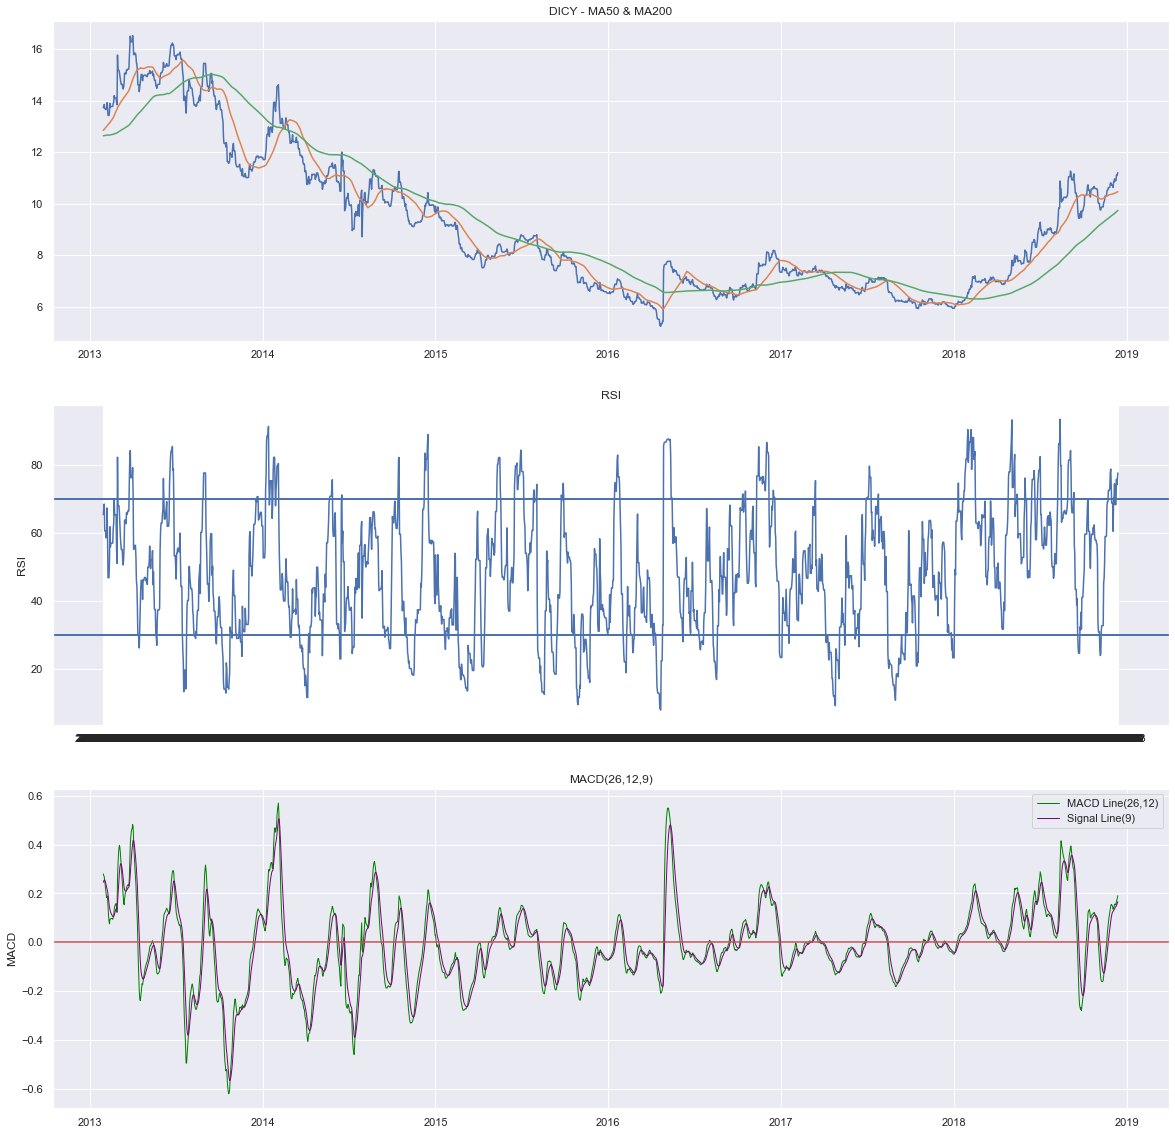

In [16]:
bonds = ['DICY']
for bond in bonds:
        # Compute features and labels  - Choose the number of future labels you want to work with 
        p_f = 5
        X = candle(bond, p_f)       
#         X = z[[bond+'_ma50vs200', bond+'_actvsma50',bond+'_actvsma200', 
#                'rsi', bond+'_rsi_trade_eval', bond+'macd',bond+'percentBB', 
#                bond+'Bandwidth',bond+'_trade_eval',bond,bond+'_future_']]
        
        X = X.join(df_CDS.Y5CDS, lsuffix='Date', rsuffix='Date')
        
        # Since we are trying to label the next p_f days we set this data apart in a dataframe        
        df_classif_test = X.iloc[-p_f:,:]
        
        # We will use the rest of the dataset to tune the parameters of teh classification model
        W = X.iloc[:-p_f,:]


In [17]:
X.shape

(2345, 18)

In [18]:
df_classif_test.shape

(5, 18)

In [19]:
W.shape

(2340, 18)

### Classification Model

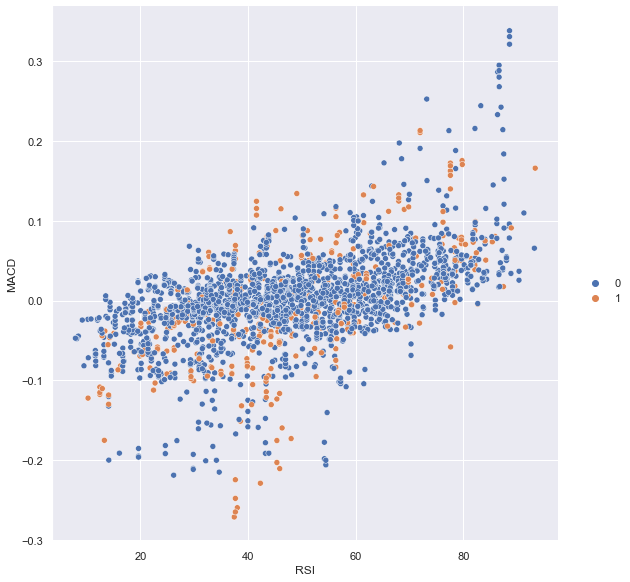

In [20]:
g = sns.FacetGrid(W, margin_titles=True, height=8)
g.map_dataframe(sns.scatterplot, x = "rsi", y = bond+'macd', hue = bond+'_trade_eval')
g.set_axis_labels("RSI", "MACD")
g.add_legend()

In [21]:
## Set features and labels
W.columns
W = W.dropna(how='any')
X_df = W[[bond+'macd', 'rsi',bond+'_ma50vs200', bond+'_actvsma50']]
y = W[bond+'_trade_eval']

In [22]:
atributos = X_df.columns

In [23]:
# Create training and validation datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.33, random_state=0)

In [24]:
#Standarize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
#Dataset is imbalanced 
np.unique(y_train, return_counts=True)

(array([0, 1]), array([1298,  235]))

In [26]:
# SMOTE: https://towardsdatascience.com/how-to-handle-smote-data-in-imbalanced-classification-problems-cf4b86e8c6a1

In [27]:
# Apply SMOTE algorithm to deal with imbalanced dataset
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)
x_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [28]:
np.unique(y_train_res, return_counts=True)

(array([0, 1]), array([1298, 1298]))

In [29]:
from sklearn.model_selection import TimeSeriesSplit
# tscv = TimeSeriesSplit(n_splits=5)
cv = StratifiedKFold(n_splits=3, random_state=41, shuffle=True)

## Random Forest Model

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
rf = RandomForestClassifier(class_weight='balanced', random_state=1)

In [32]:
param_trees = {'n_estimators': [50, 100, 200], 
               'max_features': [1, 5, 8, 10, 21], 
               'max_depth': [5, 20, 50, 70, 100], 
               'min_samples_leaf':[1, 5, 8, 10, 50]}

In [33]:
grid_search_rf = GridSearchCV(rf, param_grid=param_trees, 
                              cv=cv, verbose=1, n_jobs=3)

In [55]:
model = grid_search_rf.fit(X_train, y_train)
s = cross_val_score(model.best_estimator_, X_train, y_train, 
                    cv=cv, n_jobs=-1)

In [36]:
grid_search_rf.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=50, max_features=1,
                       n_estimators=200, random_state=1)

In [37]:
print("{}:\t{:0.3} ± {:0.3}".format("Random Forest performance:", 
                                    s.mean().round(3), s.std().round(3)))

Random Forest performance::	0.872 ± 0.003


In [38]:
y_pred_rf = grid_search_rf.best_estimator_.predict(X_test)

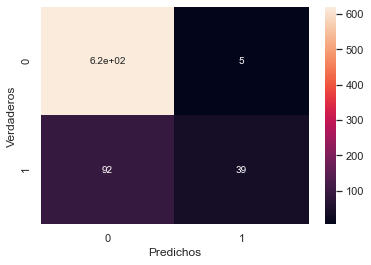

In [39]:
# Ahora calculamos la matriz de confusión
confusion_matrix(y_test, y_pred_rf)
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True)
plt.ylabel('Verdaderos')
plt.xlabel('Predichos');

In [40]:
# Classification Matrix
confusion = confusion_matrix(y_test, y_pred_rf)
print(confusion)

TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print('Accuracy Score:',round(accuracy_score(y_test, y_pred_rf),2))

class_error = (FP + FN) / float(TP + TN + FP + FN)
print('Class Error:',round(class_error),2)

sensitivity = TP / float(FN + TP)
print('Recall Score:',round(recall_score(y_test, y_pred_rf),2))

specificity = TN / (TN + FP)
print('Specificity:',round(specificity,2))

precision = TP / float(TP + FP)
print('Precision Score:',round(precision_score(y_test, y_pred_rf),2))

print('F1 Score:',round(f1_score(y_test,y_pred_rf),2))

[[620   5]
 [ 92  39]]
Accuracy Score: 0.87
Class Error: 0 2
Recall Score: 0.3
Specificity: 0.99
Precision Score: 0.89
F1 Score: 0.45


In [41]:
print(metrics.classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.87      0.99      0.93       625
           1       0.89      0.30      0.45       131

    accuracy                           0.87       756
   macro avg       0.88      0.64      0.69       756
weighted avg       0.87      0.87      0.84       756



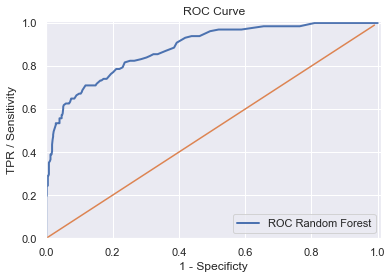

AUC Random Forest: 0.88


In [42]:
#ROC Curve
y_probs_rf = grid_search_rf.best_estimator_.predict_proba(X_test)
y_values_rf = grid_search_rf.best_estimator_.predict(X_test)
fpr_rf,tpr_rf,thr_rf = roc_curve(y_test, y_probs_rf[:,1])
df_rf = pd.DataFrame(dict(fpr=fpr_rf, tpr=tpr_rf, thr = thr_rf))
plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')

plt.plot(df_rf['fpr'],df_rf['tpr'],lw=2,label='ROC Random Forest')
plt.legend(loc="lower right")


plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.show() 
print('AUC Random Forest:',round(metrics.auc(fpr_rf, tpr_rf),2))

## AdaBoost Classifier

In [43]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

In [44]:
params_ab = {"n_estimators": [100, 500],
          "learning_rate":[0.01, 0.1, 1.0],
        "base_estimator__max_depth": [1, 2, 3]}

grid_ab = GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier()), 
                       param_grid=params_ab, cv=cv, verbose=1, n_jobs=3)


In [45]:
grid_ab.fit(x_train_res,y_train_res)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=41, shuffle=True),
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
             n_jobs=3,
             param_grid={'base_estimator__max_depth': [1, 2, 3],
                         'learning_rate': [0.01, 0.1, 1.0],
                         'n_estimators': [100, 500]},
             verbose=1)

In [46]:
grid_ab.best_params_

{'base_estimator__max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 500}

In [48]:
s = cross_val_score(grid_ab.best_estimator_, X_train, y_train, 
                    cv=cv, n_jobs=-1)

In [49]:
print("{}:\t{:0.3} ± {:0.3}".format("AdaBoost performance:", 
                                    s.mean().round(3), s.std().round(3)))

AdaBoost performance::	0.868 ± 0.002


In [50]:
y_pred = grid_ab.best_estimator_.predict(X_test)

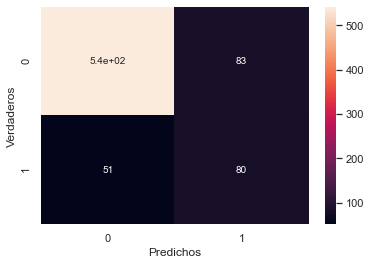

In [51]:
# Ahora calculamos la matriz de confusión
confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.ylabel('Verdaderos')
plt.xlabel('Predichos');

In [52]:
# Classification Matrix
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print('Accuracy Score:',round(accuracy_score(y_test, y_pred),2))

class_error = (FP + FN) / float(TP + TN + FP + FN)
print('Class Error:',round(class_error),2)

sensitivity = TP / float(FN + TP)
print('Recall Score:',round(recall_score(y_test, y_pred),2))

specificity = TN / (TN + FP)
print('Specificity:',round(specificity,2))

precision = TP / float(TP + FP)
print('Precision Score:',round(precision_score(y_test, y_pred),2))

print('F1 Score:',round(f1_score(y_test,y_pred),2))

[[542  83]
 [ 51  80]]
Accuracy Score: 0.82
Class Error: 0 2
Recall Score: 0.61
Specificity: 0.87
Precision Score: 0.49
F1 Score: 0.54


In [53]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89       625
           1       0.49      0.61      0.54       131

    accuracy                           0.82       756
   macro avg       0.70      0.74      0.72       756
weighted avg       0.84      0.82      0.83       756



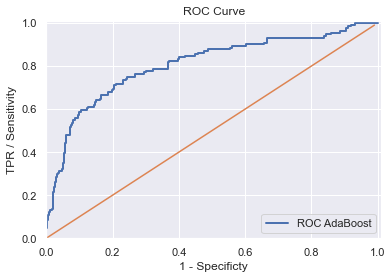

AUC AdaB: 0.81


In [54]:
#ROC Curve
y_probs_AB = grid_ab.predict_proba(X_test)
y_values_AB = grid_ab.predict(X_test)
fpr_AB,tpr_AB,thr_AB = roc_curve(y_test, y_probs_AB[:,1])
df_AB = pd.DataFrame(dict(fpr=fpr_AB, tpr=tpr_AB, thr = thr_AB))
plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')

plt.plot(df_AB['fpr'],df_AB['tpr'],lw=2,label='ROC AdaBoost')
plt.legend(loc="lower right")


plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.show() 
print('AUC AdaB:',round(metrics.auc(fpr_AB, tpr_AB),2))

- Random Forest Model shows a higher AUC than the AB model
- Random F shows a higher specificity and precision scores
- However, RF shows lower recall. This means that the model identify buying opportunities on many ocations. Further feature engineer is recommended in this case.
- Notice that the model should have been run using zero coupon rate bonds. They are not easy to calculate for Argentinean bonds. Bearing this in mind, we attempted to turn a time series problem into a classification problem we wanted and check how data fits RF and AB models chosen. 